<a href="https://colab.research.google.com/github/rahiakela/machine-learning-research-and-practice/blob/main/hands-on-machine-learning-with-scikit-learn-keras-and-tensorflow/9-unsupervised-learning-techniques/04_gaussian_mixtures.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Gaussian Mixtures

A Gaussian mixture model (GMM) is a probabilistic model that assumes that the
instances were generated from a mixture of several Gaussian distributions whose parameters are unknown. All the instances generated from a single Gaussian distribution form a cluster that typically looks like an ellipsoid.

When you observe an instance, you know it was generated from one of the Gaussian distributions, but you are not told which one, and you do not know what the parameters of these distributions are.

There are several GMM variants. In the simplest variant, implemented in the `GaussianMixture` class, you must know in advance the number $k$ of Gaussian distributions.

This generative process can be represented as a graphical model.

<img src='https://github.com/rahiakela/machine-learning-research-and-practice/blob/main/hands-on-machine-learning-with-scikit-learn-keras-and-tensorflow/9-unsupervised-learning-techniques/images/1.png?raw=1' width='600'/>

So, what can you do with such a model?

Well, given the dataset $X$, you typically want
to start by estimating the weights ϕ and all the distribution parameters $\mu(1)$ to $\mu(k)$ and
Σ(1) to Σ(k). 

Scikit-Learn’s GaussianMixture class makes this super easy.





##Setup

In [1]:
# Common imports
import numpy as np
import os
from timeit import timeit

from sklearn.mixture import GaussianMixture
from sklearn.mixture import BayesianGaussianMixture

from sklearn.model_selection import train_test_split

from sklearn.datasets import load_iris
from sklearn.datasets import make_blobs
from sklearn.datasets import load_digits
from sklearn.datasets import make_moons

from scipy.stats import norm

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.image import imread
from matplotlib.ticker import FixedLocator, FixedFormatter
from matplotlib.colors import LogNorm
from matplotlib.patches import Polygon

mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

Let's define some ploting methods.

In [18]:
def plot_data(X):
    plt.plot(X[:, 0], X[:, 1], 'k.', markersize=2)

def plot_centroids(centroids, weights=None, circle_color='w', cross_color='k'):
    if weights is not None:
        centroids = centroids[weights > weights.max() / 10]
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='o', s=30, linewidths=8,
                color=circle_color, zorder=10, alpha=0.9)
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='x', s=50, linewidths=50,
                color=cross_color, zorder=11, alpha=1)

In [ ]:
def plot_decision_boundaries(clusterer, X, resolution=1000, show_centroids=True,
                             show_xlabels=True, show_ylabels=True):
    mins = X.min(axis=0) - 0.1
    maxs = X.max(axis=0) + 0.1
    xx, yy = np.meshgrid(np.linspace(mins[0], maxs[0], resolution),
                         np.linspace(mins[1], maxs[1], resolution))
    Z = clusterer.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),
                cmap="Pastel2")
    plt.contour(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),
                linewidths=1, colors='k')
    plot_data(X)
    if show_centroids:
        plot_centroids(clusterer.cluster_centers_)

    if show_xlabels:
        plt.xlabel("$x_1$", fontsize=14)
    else:
        plt.tick_params(labelbottom=False)
    if show_ylabels:
        plt.ylabel("$x_2$", fontsize=14, rotation=0)
    else:
        plt.tick_params(labelleft=False)

In [2]:
def plot_gaussian_mixture(clusterer, X, resolution=1000, show_ylabels=True):
    mins = X.min(axis=0) - 0.1
    maxs = X.max(axis=0) + 0.1
    xx, yy = np.meshgrid(np.linspace(mins[0], maxs[0], resolution),
                         np.linspace(mins[1], maxs[1], resolution))
    Z = -clusterer.score_samples(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(xx, yy, Z,
                 norm=LogNorm(vmin=1.0, vmax=30.0),
                 levels=np.logspace(0, 2, 12))
    plt.contour(xx, yy, Z,
                norm=LogNorm(vmin=1.0, vmax=30.0),
                levels=np.logspace(0, 2, 12),
                linewidths=1, colors='k')

    Z = clusterer.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.contour(xx, yy, Z,
                linewidths=2, colors='r', linestyles='dashed')
    
    plt.plot(X[:, 0], X[:, 1], 'k.', markersize=2)
    plot_centroids(clusterer.means_, clusterer.weights_)

    plt.xlabel("$x_1$", fontsize=14)
    if show_ylabels:
        plt.ylabel("$x_2$", fontsize=14, rotation=0)
    else:
        plt.tick_params(labelleft=False)

In [21]:
def compare_gaussian_mixtures(gm1, gm2, X):
    plt.figure(figsize=(9, 4))

    plt.subplot(121)
    plot_gaussian_mixture(gm1, X)
    plt.title('covariance_type="{}"'.format(gm1.covariance_type), fontsize=14)

    plt.subplot(122)
    plot_gaussian_mixture(gm2, X, show_ylabels=False)
    plt.title('covariance_type="{}"'.format(gm2.covariance_type), fontsize=14)

In [3]:
X1, y1 = make_blobs(n_samples=1000, centers=((4, -4), (0, 0)), random_state=42)
X1 = X1.dot(np.array([[0.374, 0.95], [0.732, 0.598]]))
X2, y2 = make_blobs(n_samples=250, centers=1, random_state=42)
X2 = X2 + [6, -8]
X = np.r_[X1, X2]
y = np.r_[y1, y2]

##Gaussian mixture model

Let's train a Gaussian mixture model on the moon dataset:

In [4]:
gm = GaussianMixture(n_components=3, n_init=10, random_state=42)
gm.fit(X)

GaussianMixture(n_components=3, n_init=10, random_state=42)

Let's look at the parameters that the EM algorithm estimated:

In [5]:
gm.weights_

array([0.39025715, 0.40007391, 0.20966893])

In [6]:
gm.means_

array([[ 0.05131611,  0.07521837],
       [-1.40763156,  1.42708225],
       [ 3.39893794,  1.05928897]])

In [7]:
gm.covariances_

array([[[ 0.68799922,  0.79606357],
        [ 0.79606357,  1.21236106]],

       [[ 0.63479409,  0.72970799],
        [ 0.72970799,  1.1610351 ]],

       [[ 1.14833585, -0.03256179],
        [-0.03256179,  0.95490931]]])

You can check whether or not the algorithm converged and how many iterations it
took:

In [8]:
gm.converged_

True

Yes, good. How many iterations did it take?

In [9]:
gm.n_iter_

4

You can now use the model to predict which cluster each instance belongs to (hard clustering) or the probabilities that it came from each cluster. 

For this, just use `predict()` method or the `predict_proba()` method:

In [10]:
gm.predict(X)

array([0, 0, 1, ..., 2, 2, 2])

In [11]:
gm.predict_proba(X)

array([[9.76741808e-01, 6.78581203e-07, 2.32575136e-02],
       [9.82832955e-01, 6.76173663e-04, 1.64908714e-02],
       [7.46494398e-05, 9.99923327e-01, 2.02398402e-06],
       ...,
       [4.26050456e-07, 2.15512941e-26, 9.99999574e-01],
       [5.04987704e-16, 1.48083217e-41, 1.00000000e+00],
       [2.24602826e-15, 8.11457779e-41, 1.00000000e+00]])

A Gaussian mixture model is a generative model, meaning you can sample new
instances from it (note that they are ordered by cluster index):

In [12]:
x_new, y_new = gm.sample(6)
x_new

array([[-0.86944074, -0.32767626],
       [ 0.29836051,  0.28297011],
       [-2.8014927 , -0.09047309],
       [ 3.98203732,  1.49951491],
       [ 3.81677148,  0.53095244],
       [ 2.84104923, -0.73858639]])

In [13]:
y_new

array([0, 0, 1, 2, 2, 2])

Notice that they are sampled sequentially from each cluster.

You can also estimate the log of the _probability density function_ (PDF) at any location using the `score_samples()` method:

In [15]:
gm.score_samples(X)

array([-2.60768954, -3.57110232, -3.32987086, ..., -3.51347241,
       -4.39798588, -3.80746532])

Let's check that the PDF integrates to 1 over the whole space. 

We just take a large square around the clusters, and chop it into a grid of tiny squares, then we compute the approximate probability that the instances will be generated in each tiny square (by multiplying the PDF at one corner of the tiny square by the area of the square), and finally summing all these probabilities). The result is very close to 1:

In [16]:
resolution = 100
grid = np.arange(-10, 10, 1 / resolution)
xx, yy = np.meshgrid(grid, grid)
x_full = np.vstack([xx.ravel(), yy.ravel()]).T

pdf = np.exp(gm.score_samples(x_full))
pdf_probas = pdf * (1 / resolution) ** 2
pdf_probas.sum()

0.9999999999215021

Now let's plot the resulting decision boundaries (dashed lines) and density contours:

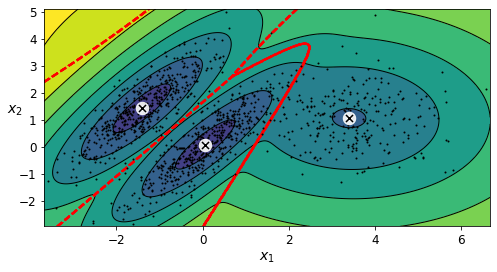

In [19]:
plt.figure(figsize=(8, 4))

plot_gaussian_mixture(gm, X)

plt.show()

Nice! The algorithm clearly found an excellent solution.

Of course, we made its task
easy by generating the data using a set of 2D Gaussian distributions (unfortunately,
real-life data is not always so Gaussian and low-dimensional).

We also gave the algorithm
the correct number of clusters. When there are many dimensions, or many
clusters, or few instances, EM can struggle to converge to the optimal solution.

You
might need to reduce the difficulty of the task by limiting the number of parameters
that the algorithm has to learn. One way to do this is to limit the range of shapes and
orientations that the clusters can have.

This can be achieved by imposing constraints
on the covariance matrices.

You can impose constraints on the covariance matrices that the algorithm looks for by setting the `covariance_type` hyperparameter:
* `"full"` (default): no constraint, all clusters can take on any ellipsoidal shape of any size.
* `"tied"`: all clusters must have the same shape, which can be any ellipsoid (i.e., they all share the same covariance matrix).
* `"spherical"`: all clusters must be spherical, but they can have different diameters (i.e., different variances).
* `"diag"`: clusters can take on any ellipsoidal shape of any size, but the ellipsoid's axes must be parallel to the axes (i.e., the covariance matrices must be diagonal).

In [20]:
gm_full = GaussianMixture(n_components=3, n_init=10, covariance_type="full", random_state=42)
gm_tied = GaussianMixture(n_components=3, n_init=10, covariance_type="tied", random_state=42)
gm_spherical = GaussianMixture(n_components=3, n_init=10, covariance_type="spherical", random_state=42)
gm_diag = GaussianMixture(n_components=3, n_init=10, covariance_type="diag", random_state=42)

gm_full.fit(X)
gm_tied.fit(X)
gm_spherical.fit(X)
gm_diag.fit(X)

GaussianMixture(covariance_type='diag', n_components=3, n_init=10,
                random_state=42)

By default, covariance_type is equal to "full", which means that each cluster can
take on any shape, size, and orientation (it has its own unconstrained covariance
matrix).

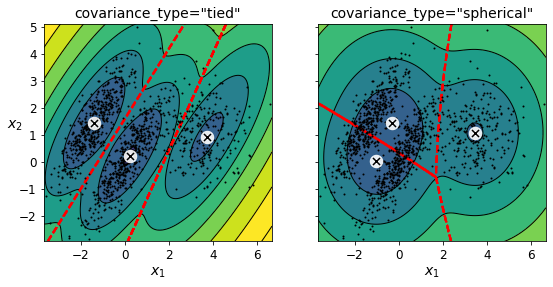

In [22]:
compare_gaussian_mixtures(gm_tied, gm_spherical, X)

plt.show()

The computational complexity of training a GaussianMixture
model depends on the number of instances $m$, the number of
dimensions $n$, the number of clusters $k$, and the constraints on the
covariance matrices. 

If `covariance_type` is "spherical or "diag", it is $O(kmn)$, assuming the data has a clustering structure. 

If `covariance_type` is "tied" or "full", it is $O(kmn2 + kn3)$, so it will not scale to large numbers of features.

Gaussian mixture models can also be used for anomaly detection.

##Anomaly Detection Using Gaussian Mixtures

Scikit-Learn implements several more clustering algorithms that you should take a look at.